In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [51]:
nflx = yf.Ticker("NFLX")

In [74]:
df_nflx = nflx.history(interval="1wk", start='2012-10-29', end='2022-11-22')
df_nflx.set_index("Date", inplace=True)

In [75]:
df_nflx['Adj_Close_12w'] = df_nflx['Adj Close'].shift(-12)

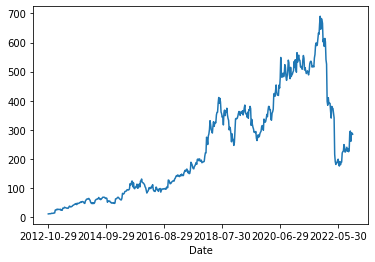

In [40]:
df_nflx["Adj Close"].plot()

In [235]:
# 80/20 split of train, test sets
X = df_nflx.loc[:, df_nflx.columns!="Adj_Close_12w"]
y = df_nflx[["Adj_Close_12w"]]
X_train, y_train = X.iloc[:(X.shape[0]//5 * 4)], y.iloc[:(y.shape[0]//5 * 4)]
X_test, y_test = X.iloc[(X.shape[0]//5 * 4):], y.iloc[(y.shape[0]//5 * 4):]

In [269]:
X['mom_6m'] = X["Adj Close"].shift(4)/X["Adj Close"].shift(28)
X['mom_12m'] = X["Adj Close"].shift(4)/X["Adj Close"].shift(52)

In [317]:
df_old = nflx.history(interval='1wk', start='2011-10-31', end='2012-10-22')

In [340]:
X_mom = df_old.append(X)
X_mom['mom_6m'] = X_mom["Adj Close"].shift(4)/X_mom["Adj Close"].shift(28)
X_mom['mom_12m'] = X_mom["Adj Close"].shift(4)/X_mom["Adj Close"].shift(52)

In [343]:
X_mom = X_mom.dropna()
X_mom

,Open,High,Low,Close,Volume,Adj Close,mom_6m,mom_12m
Date,,,,,,,,
2012-10-29,9.487143,12.135714,9.364286,10.985714,199628800,10.985714,0.627274,0.739391
2012-11-05,10.652857,11.475714,10.642857,11.128571,155873200,11.128571,0.768211,0.733105
2012-11-12,11.285714,11.871429,11.048571,11.557143,121976400,11.557143,0.888433,0.832437
2012-11-19,11.715714,12.080000,11.450000,11.850000,57894200,11.850000,0.899199,1.089571
2012-11-26,11.800000,11.938571,11.332857,11.672857,69963600,11.672857,1.099200,1.158656
...,...,...,...,...,...,...,...,...
2022-10-24,290.230011,305.630005,280.359985,295.720001,68714300,295.720001,0.690177,0.341064
2022-10-31,295.130005,299.700012,255.320007,260.790009,42965700,260.790009,1.042827,0.348061
2022-11-07,261.059998,290.660004,252.089996,290.130005,42111400,290.130005,1.208237,0.336942


In [355]:
X_mom["Adj_Close_12w"] = X_mom["Adj Close"].shift(12)

In [383]:
X_mom["Adj_Close_12w"] = X_mom["Adj Close"].shift(-12)
y_mom = X_mom[["Adj_Close_12w"]]
X_mom = X_mom.loc[:, X_mom.columns!="Adj_Close_12w"]
X_train, y_train = X_mom.iloc[:(X_mom.shape[0]//5 * 3)], y_mom.iloc[:(y_mom.shape[0]//5 * 3)]
X_val, y_val = X.iloc[(X_mom.shape[0]//5 * 3):(X_mom.shape[0]//5 * 4)], y_mom.iloc[(y_mom.shape[0]//5 * 3):(y_mom.shape[0]//5 * 4)]
X_test, y_test = X.iloc[(X_mom.shape[0]//5 * 4):], y_mom.iloc[(y_mom.shape[0]//5 * 4):]

In [384]:
X_test, y_test = X_test.iloc[:-12], y_test.iloc[:-12]

In [9]:
model = RandomForestRegressor()
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(X_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.4min finished
C:\Users\Paul\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4, 'bootstrap': False}


In [10]:
model = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=4, bootstrap=False, random_state=42)
model.fit(X_train, y_train.squeeze())

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

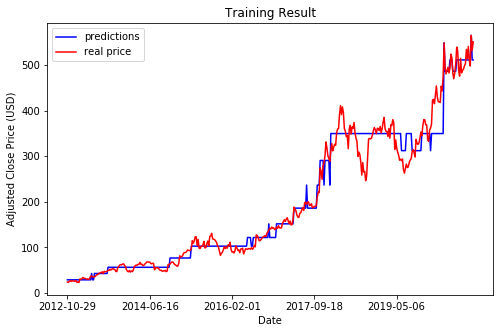

In [36]:
train_preds = pd.Series(data=model.predict(X_train), index=X_train.index)
plt.figure(figsize=(8,5))
plt.plot(train_preds, 'b', label="predictions")
plt.plot(y_train, 'r', label="real price")
plt.xticks(train_preds.index[::85])
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.title("Training Result")
plt.legend()

plt.savefig("train_result.png")
plt.show()

In [49]:
print("Training Error:", metrics.mean_absolute_error(y_train, train_preds))

Training Error: 16.248723519023738


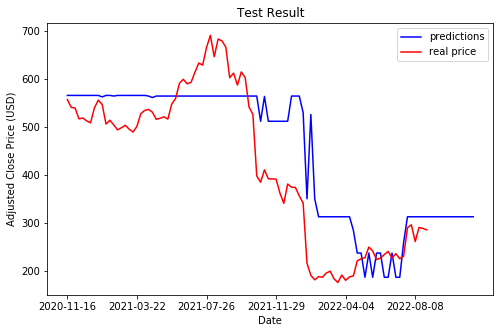

In [37]:
test_preds = pd.Series(data=model.predict(X_test), index=X_test.index)
plt.figure(figsize=(8,5))
plt.plot(test_preds, 'b', label='predictions')
plt.plot(y_test, 'r', label='real price')
plt.xticks(X_test.index[::18])
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.title("Test Result")
plt.legend()
plt.savefig("test_result.png")
plt.show()

In [50]:
print("Test Error:", metrics.mean_absolute_error(y_test.iloc[:-12], test_preds.loc[:"2022-09"]))

Test Error: 73.25594360161911


In [57]:
pd.DataFrame(data=model.predict(X_mom.iloc[-2:]), index=X_mom.iloc[-2:].index, columns=["price in 12wk"])

,price in 12wk
Date,
2022-11-14,312.341251
2022-11-21,312.341251
